In [2]:
# =====================================================================================
# This code is a solution for MSBD5001-Fall2020 kaggle competition
# Created by JiangJiahang using google colab in Nov.2020
# Note: Install and import the package wwo-hist to get historical weather condition
# =====================================================================================

In [5]:
pip install wwo-hist

In [9]:
# set the path
WEATHER_DIR = '/content/drive/My Drive/5001/data/'
WEATHER_PATH = '/content/drive/My Drive/5001/data/hongkong.csv'

TRAIN_PATH = '/content/drive/My Drive/5001/data/train.csv'
TEST_PATH = '/content/drive/My Drive/5001/data/test.csv'
MODEL_PATH = '/content/drive/My Drive/5001/data/model_best.dat'
RES_PATH = '/content/drive/My Drive/5001/data/result_final.csv'

In [6]:
# import python package needed
import numpy as np
import pandas as pd
import lightgbm as lgb
import pickle
import holidays
from datetime import date,datetime
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import os
from wwo_hist import retrieve_hist_data
import urllib.request
# set the figure shape
rcParams['figure.figsize'] = 150, 6

## (1) get the weather features using the package: wwo-hist

In [22]:
# set the work space to store the retrieved weather condition dataframe
## remember to get a new api_key from https://www.worldweatheronline.com/, when this one doesn't work,
##             or just use the same file which I have put in the directory: ./data, then you can ignore the code in this cell
os.chdir(WEATHER_DIR)

## based on one day
frequency = 24 
start_date = '01-Jan-2017'
end_date = '31-DEC-2018'
## set the API_KEY
api_key = 'dfc07b5a0b1b451ba9d22824200312'
location_list = ['hongkong']

# stroed in .csv format
hist_weather_data = retrieve_hist_data(api_key, location_list, start_date, end_date, frequency = 24, export_csv = True, store_df = True)



Retrieving weather data for hongkong


Currently retrieving data for hongkong: from 2017-01-01 to 2017-01-31
Time elapsed (hh:mm:ss.ms) 0:00:01.152109
Currently retrieving data for hongkong: from 2017-02-01 to 2017-02-28
Time elapsed (hh:mm:ss.ms) 0:00:02.136290
Currently retrieving data for hongkong: from 2017-03-01 to 2017-03-31
Time elapsed (hh:mm:ss.ms) 0:00:03.188588
Currently retrieving data for hongkong: from 2017-04-01 to 2017-04-30
Time elapsed (hh:mm:ss.ms) 0:00:04.183666
Currently retrieving data for hongkong: from 2017-05-01 to 2017-05-31
Time elapsed (hh:mm:ss.ms) 0:00:05.198398
Currently retrieving data for hongkong: from 2017-06-01 to 2017-06-30
Time elapsed (hh:mm:ss.ms) 0:00:06.166968
Currently retrieving data for hongkong: from 2017-07-01 to 2017-07-31
Time elapsed (hh:mm:ss.ms) 0:00:07.267600
Currently retrieving data for hongkong: from 2017-08-01 to 2017-08-31
Time elapsed (hh:mm:ss.ms) 0:00:08.275259
Currently retrieving data for hongkong: from 2017-09-01 to 2017

In [10]:
# get useful weather conditions from the output file

dateparse = lambda dates: datetime.strptime(dates, '%Y-%m-%d')
# df_raw = pd.read_csv(TRAIN_PATH, parse_dates=['date'], index_col='date', date_parser=dateparse)
df_weather = pd.read_csv(WEATHER_PATH, parse_dates=['date_time'], index_col='date_time', date_parser=dateparse)
weather_features = df_weather[['tempC','visibility','winddirDegree','windspeedKmph','humidity','cloudcover', 'WindChillC']]

## (2)  Data pre-processing

length of the training set: 14006


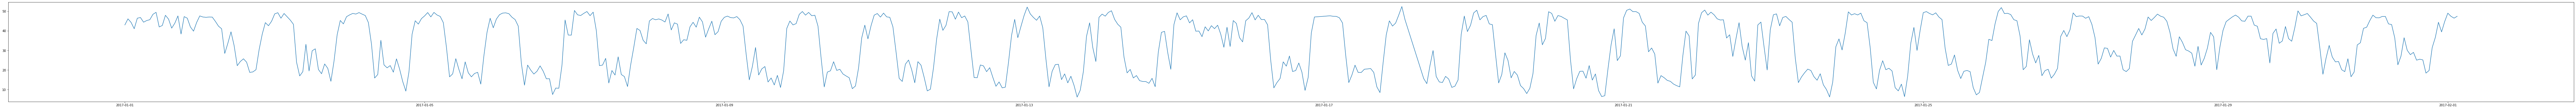

In [11]:
# read the training set and check
dateparse = lambda dates: datetime.strptime(dates, '%d/%m/%Y %H:%M')
df_raw = pd.read_csv(TRAIN_PATH, parse_dates=['date'], index_col='date', date_parser=dateparse)
print('length of the training set:', len(df_raw))
plt.plot(df_raw['speed']['2017-01-01 00:00:00':'2017-02-01 03:00:00'])

In [12]:
# change the order randomly
## use a fixed seed
np.random.seed(2020)
new_index = np.random.permutation(df_raw.index)
df = df_raw.reindex(new_index)

## (3) 10-fold cross-validation

In [13]:
# get the training set and testing set for each fold
data_train = []
data_test = []
num_fold = 10
length_fold = len(df)//num_fold

## get the testing set first, 
## then training = all - testing
for i in range(num_fold):
  begin = i*length_fold
  ## deal with the last fold specially
  end = begin + length_fold if i!=(num_fold-1) else len(df)
  data_test.append(df[begin:end])
  diff_df = pd.concat([df, df[begin:end], df[begin:end]]).drop_duplicates(keep=False)
  data_train.append(diff_df)
# check the training set
print(data_train)

[                        id      speed
date                                 
2017-12-04 18:00:00   8096  12.040656
2017-02-28 11:00:00   1394  23.916077
2017-05-07 21:00:00   3036  37.817354
2017-09-25 10:00:00   6408  22.090556
2017-10-03 15:00:00   6605  18.212369
...                    ...        ...
2017-03-31 12:00:00   2139  13.125757
2018-08-06 16:00:00  11971  22.381420
2017-11-09 13:00:00   7491  18.474344
2018-09-25 13:00:00  12680  31.566724
2018-01-22 03:00:00   9056  46.862613

[12606 rows x 2 columns],                         id      speed
date                                 
2018-07-03 12:00:00  11456  20.690847
2017-10-23 08:00:00   7078  17.556126
2018-02-20 22:00:00   9496  42.699130
2018-12-15 07:00:00  13777  40.552861
2017-02-02 02:00:00    761  48.488925
...                    ...        ...
2017-03-31 12:00:00   2139  13.125757
2018-08-06 16:00:00  11971  22.381420
2017-11-09 13:00:00   7491  18.474344
2018-09-25 13:00:00  12680  31.566724
2018-01-22 03:00:00   

In [14]:
# get features from time series and weather condition

def get_features(df, weather_features, label=None):
  ## index: DatetimeIndex
  df['date'] = df.index

  ## date_by_year/year/month/quarter/day/hour
  df['date_by_year'] = df['date'].dt.date
  df['year'] = df['date'].dt.year
  df['month'] = df['date'].dt.month
  df['quarter'] = df['date'].dt.quarter
  df['day'] = df['date'].dt.day
  df['hour'] = df['date'].dt.hour

  ## day_of_year/day_of_week/week_of_year
  df['day_of_year'] = df['date'].dt.dayofyear
  df['day_of_week'] = df['date'].dt.dayofweek
  df['week_of_year'] = df['date'].dt.weekofyear

  ## is_holiday
  hk_holidays = holidays.HK()
  is_holidays = []
  for i in df['date_by_year']:
    is_holidays.append(int(i in hk_holidays))
  df['is_holiday'] = is_holidays

  ## is_weekend
  is_weekends = []
  for i in df['day_of_week']:
    is_weekends.append(int(i in [5,6]))
  df['is_weekend'] = is_weekends

  ## weather condition
  tempC = []
  visibility = []
  winddirDegree = []
  windspeedKmph = []
  humidity = []
  cloudcover = []
  WindChillC = []

  for i in df['date_by_year']:
    # transform the type from date to datetime
    string_date = str(i)
    date = datetime.strptime(string_date, '%Y-%m-%d')
    tempC.append(weather_features['tempC'][date])
    visibility.append(weather_features['visibility'][date])
    winddirDegree.append(weather_features['winddirDegree'][date])
    windspeedKmph.append(weather_features['windspeedKmph'][date])
    humidity.append(weather_features['humidity'][date])
    cloudcover.append(weather_features['cloudcover'][date])
    WindChillC.append(weather_features['WindChillC'][date])

  df['tempC'] = tempC
  df['visibility'] = visibility
  df['winddirDegree'] = winddirDegree
  df['windspeedKmph'] = windspeedKmph
  df['humidity'] = humidity
  df['cloudcover'] = cloudcover
  df['WindChillC'] = WindChillC


  Features = df[['year', 'month', 'quarter', 'day', 'hour', 'day_of_year', 'day_of_week', 'week_of_year', 'is_holiday', 'is_weekend',\
                 'tempC', 'visibility', 'winddirDegree', 'windspeedKmph', 'humidity', 'cloudcover', 'WindChillC']]
  if label:
    y = df[label]
    return Features, y
  return Features

In [15]:
# train and find the best model

best_i = 0
best_loss = None

for i in range(num_fold):
  X_train, y_train = get_features(data_train[i], weather_features, label='speed')
  X_test, y_test = get_features(data_test[i], weather_features, label='speed')

  # set parameters
  param = {'max_depth': 10, 'num_leaves': 100, 'num_trees':400, 'objective':'regression', 'iterations':1000, 'learning_rate':0.1, 'metric':'mse'}
  data_train_cur = lgb.Dataset(X_train, y_train)
  model = lgb.train(param, data_train_cur)
  y_pred = model.predict(X_test)
  
  ## print the new mse loss for each fold
  new_loss = sum((y_pred - y_test)**2)/len(y_pred)
  print("=================================")
  print("(%d) MSE:%.8f"%(i, new_loss))

  if not best_loss or new_loss < best_loss:
    ## save the best model
    pickle.dump(model, open(MODEL_PATH, "wb"))
    best_loss = new_loss
    best_i = i
print('best fold: ', best_i)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A valu

(0) MSE:9.45920018
(1) MSE:10.92476244
(2) MSE:10.85787831
(3) MSE:10.38978756
(4) MSE:10.10853293
(5) MSE:10.83118924
(6) MSE:9.99181093
(7) MSE:10.13907378
(8) MSE:10.98221034
(9) MSE:10.72588602
best fold:  0


## (3) Check the best model



In [16]:
# check the mse loss of the best model
model_best = pickle.load(open(MODEL_PATH, "rb"))
X_test, y_test = get_features(data_test[best_i], weather_features, label='speed')
y_pred = model_best.predict(X_test)
loss = sum((y_pred - y_test)**2)/len(y_pred)
print("==========================")
print(loss)
print("==========================")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

9.459200181880023


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

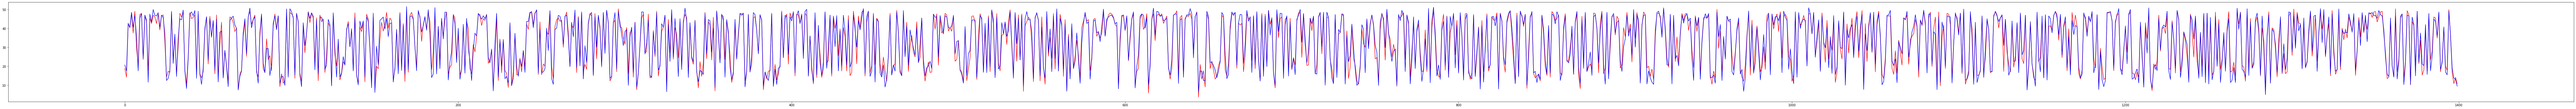

In [17]:
# check the testing result in an overall view
plt.plot(y_pred, 'r', label='prediction')
plt.plot(y_test.values, 'b', label='real')

## (4) Load the test dataset and make prediction

In [18]:
# read the testing set and check
dateparse = lambda dates: datetime.strptime(dates, '%d/%m/%Y %H:%M')
data_test2 = pd.read_csv(TEST_PATH, parse_dates=['date'],index_col='date',date_parser=dateparse)
print('length of the testing set:', len(data_test2))
data_test2

length of the testing set: 3504


,id
date,
2018-01-01 02:00:00,0
2018-01-01 05:00:00,1
2018-01-01 07:00:00,2
2018-01-01 08:00:00,3
2018-01-01 10:00:00,4
...,...
2018-12-31 17:00:00,3499
2018-12-31 19:00:00,3500
2018-12-31 21:00:00,3501


In [19]:
# get features and make prediction
X_test2 = get_features(data_test2, weather_features)
y_pred2 = model_best.predict(X_test2)
y_pred2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


array([47.52388803, 47.65541317, 40.21688322, ..., 45.9823544 ,
       42.05046713, 43.42894058])

In [20]:
# transform the output to the standard form
id = range(len(y_pred2))
res = pd.DataFrame({'id':id,'speed':y_pred2}).set_index('id')
res

,speed
id,
0,47.523888
1,47.655413
2,40.216883
3,31.296464
4,41.080980
...,...
3499,13.797110
3500,26.308708
3501,45.982354


In [21]:
# save the result
res.to_csv(RES_PATH)